<span style="font-size:2em;">**Routing Environment Task 2**</span>

In [1]:
from networkx import nx
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
import random
import time
from IPython.display import clear_output
from gym.spaces import Tuple, Discrete, Box, MultiDiscrete

<span style="font-size:1.5em;">**Creating the Enviornment**</span>

In [2]:
class Network(gym.Env ):
    
    # initalize the class
    def __init__(self, configuration: dict):

        self.graph =  self.create_graph(config['Source'] , config['Sink'], config['Number_of_nodes'] )
        self.num_nodes = len(self.graph.nodes())
        self.num_links = len(self.graph.edges())
        state_space = [nodes for nodes in self.graph.nodes]
        action_space = [list(self.graph.adj[node]) for node in self.graph.nodes]
        self.state_space = state_space
        self.action_space = state_space
        self.available_actions = action_space
        self.num_states = len(state_space)
        self.num_actions = len(state_space)
        self.source  = config['Source']
        self.current_state = config['Source']
        self.sink = config['Sink']
        self.number_of_nodes = config['Number_of_nodes']
        self.arrival_time = config['arrival_time']
        self.current_timestep = 0
        

    # Create Graph
    def create_graph( self , source , sink , n):
        G = nx.Graph()
        for i in range(0 , n):
            G.add_node( i , Source = False , Sink = False , Packet = [] , Hopcount = 0)
        G.add_edges_from([(0 , 1) , (1 , 3) , (3 , 4) , (0 , 2) , (1 , 4) , (4,7) , (3,5) , (5,6),
                          (2, 7) , (1, 5)])
        G.nodes[source]['Source'] = True
        G.nodes[source]['Packet'] = [1]
        G.nodes[sink]['Sink'] = True
        self.current_state = source
        return G
    
    # The action to be taken
    def step(self, action):
        # If the action is valid, i.e transmitting from current node to
        # another node is possible then only transfer
        index = self.current_state
        # 1. If action is allowed and the next node is sink node then reward = 1
        # 2. If action is allowed and the next node is not sink node then reward = -1
        # 3. If action is not allowed (i.e no edge between the current node and the next node) then reward = -5
        if action in self.available_actions[index]:
            self.transmit(self.current_state , action)
            if self.graph.nodes[action]['Sink'] == True :
                self.current_state = action
                done = True
                next_state = action
                reward = 1
            else :
                self.current_state = action
                next_state = action
                done = False
                reward = -1
        else:
            reward = -5
            next_state = self.current_state
            done = False
            
        # For rendering
        unwanted_num = {self.current_state , self.sink}
        self.remaining_nodes = [ elem for elem in self.state_space if elem not in unwanted_num]
        
        return next_state , reward , done , 1
        
        
    def transmit(self, source, destination):
        self.graph.nodes[source]['Packet'] = []
        self.graph.nodes[destination]['Hopcount'] = self.graph.nodes[source]['Hopcount'] + 1
        self.graph.nodes[destination]['Packet'] = [1]
        
    
    def reset(self ):
        self.graph =  self.create_graph( self.source , self.sink , self.number_of_nodes)
        self.current_state = self.source
        unwanted_num = {self.current_state , self.sink}
        
        self.remaining_nodes = [ elem for elem in self.state_space if elem not in unwanted_num]
        return self.current_state


    def render(self, mode='human'):
        # The current node list
        list_current = [self.current_state]
        # The sink node list
        list_sink = [self.sink]
        # The list which contains all the nodes except current node and sink node
        list_nodes =  self.remaining_nodes
        
        # Assigning labels to the nodes
        labels = {}
        labels[0] = '$0$'
        labels[1] = '$1$'
        labels[2] = '$2$'
        labels[3] = '$3$'
        labels[4] = '$4$'
        labels[5] = '$5$'
        labels[6] = '$6$'
        labels[7] = '$7$'
        pos = nx.spring_layout(self.graph)
        nx.draw_networkx_nodes(self.graph , pos , with_labels = True , nodelist = list_current, node_color = 'red')
        nx.draw_networkx_nodes(self.graph , pos , with_labels = True , nodelist = list_sink , node_color = 'green')
        nx.draw_networkx_nodes(self.graph , pos , with_labels = True , nodelist = list_nodes , node_color = 'blue')
        nx.draw_networkx_edges(self.graph , pos ,
                               edgelist =[(0 , 1) , (1 , 3) , (3 , 4) , (0 , 2) , (1 , 4) , (4,7) , (3,5) , (5,6),
                                          (2, 7) , (1, 5)],
                               alpha = 0.5 , edge_color = 'black')
        nx.draw_networkx_labels(self.graph , pos , labels , font_size = 10)
        plt.axis('off')
        plt.show(block = False)
        plt.pause(5)
        plt.close('all')

<span style="font-size:1.5em;">**The Main Program**</span>

*********Episode  1 ******
The source is 1 and the destination is 7 




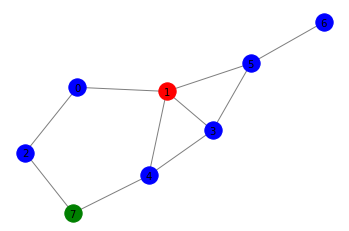

Next_state 4 Reward :  -1 Done False


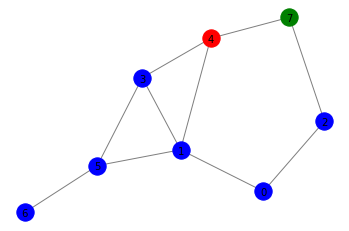

Next_state 7 Reward :  1 Done True


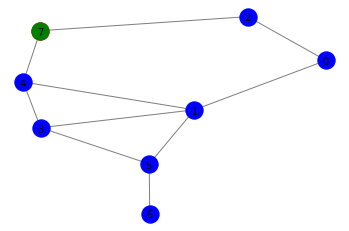

You reached Goal

*********Episode  2 ******
The source is 1 and the destination is 7 




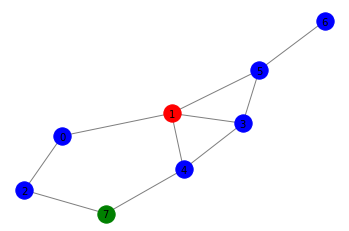

Next_state 4 Reward :  -1 Done False


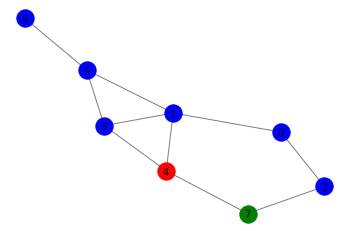

Next_state 7 Reward :  1 Done True


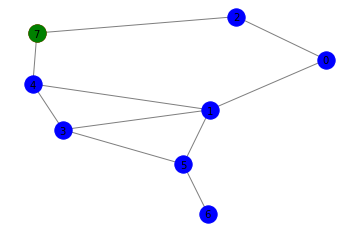

You reached Goal

*********Episode  3 ******
The source is 1 and the destination is 7 




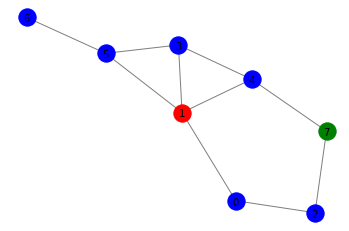

Next_state 4 Reward :  -1 Done False


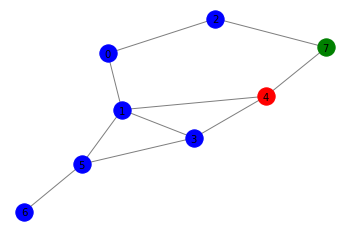

Next_state 7 Reward :  1 Done True


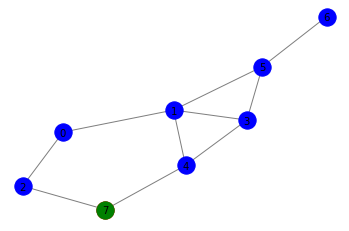

You reached Goal



In [3]:
if __name__ == '__main__':
    config = {}
    config['Source'] = 1
    config['Sink'] = 7
    config['Number_of_nodes'] = 8
    config['arrival_time'] = 2
    
    env = Network( config )
    action_sapce_size = env.num_states
    action_space = env.action_space
    state_space_size = env.num_actions

    # Now we create a q table using the action space and state space size
    q_table = np.zeros((state_space_size , action_sapce_size))

    num_episodes = 10000  # Number of episodes we want our agent to play
    max_steps_per_episode = 10  # Maximum number of steps out agent is allowed to take in a single episode

    learning_rate = 0.1  # Symbol Alpha
    discount_rate = 0.99  # Symbol Gamma

    # Allparameters related to exploration exploitation tradeoff using the greedy strategy
    exploration_rate = 1  # initialiing the exploration rate (epsilon)
    max_exploration_Rate = 1
    min_exploration_Rate = 0.01
    exploration_decay_rate = 0.001  # The rate at which exploration rate will decay

    rewards_all_episodes = []

    for episode in range(num_episodes) :  # For all the episodes
        state = env.reset()
    
        done = False
        rewards_current_episode = 0
    
        for step in range(max_steps_per_episode) :
        
            # Exploration-exploitation trade-off
            exploration_rate_threshold = random.uniform(0 , 1)
            if exploration_rate_threshold > exploration_rate :
                action = np.argmax(q_table[state , :])
            else :
                action = random.randrange(0,8)
        
            new_state , reward , done , info = env.step(action)

            # Update Q-table for Q(s,a)
            q_table[state , action] = q_table[state , action] * (1 - learning_rate) + \
                                      learning_rate * (reward + discount_rate * np.max(q_table[new_state , :]))
        
            state = new_state
            rewards_current_episode += reward
        
            if done == True :
                break
    
        exploration_rate = min_exploration_Rate + \
                           (max_exploration_Rate - min_exploration_Rate) * np.exp(-exploration_decay_rate * episode)
    
        rewards_all_episodes.append((rewards_current_episode))


    for episode in range(3) :
        state = env.reset()
        done = False
        print("*********Episode " , episode + 1 , "******")
        print("The source is {}".format(config['Source']),"and the destination is {} \n\n".format(config['Sink']) )
        time.sleep(1)
    
        for step in range(max_steps_per_episode) :
            #clear_output(wait = True)
            env.render()
            
        
            action = np.argmax(q_table[state , :])
            new_state , reward , done , info = env.step(action)
            print("Next_state",new_state , "Reward : ", reward , "Done" , done)
            
        
            if done :
                #clear_output(wait = True)
                env.render()
                print("You reached Goal")
                time.sleep(3)
                break
            state = new_state
        print()
    env.close()